In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [39]:
class enco(nn.Module):
    def __init__(self):
        super(enco,self).__init__()
        self.lay1=nn.Conv2d(1,16,3,stride=2,padding=1)
        self.lay2=nn.Conv2d(16,32,3,stride=2,padding=1)
        self.relu=nn.ReLU()
        self.layLast=nn.Conv2d(32,64,7)
        self.drop=nn.Dropout(0.2)
    def forward(self,x):
        x=self.lay1(x)
        #print(x.shape)
        x=self.relu(x)
        #print(x.shape)
        x=self.drop(x)
        #print(x.shape)
        x=self.lay2(x)
        #print(x.shape)
        x=self.relu(x)
        #print(x.shape)
        x=self.layLast(x)
        #print(x.shape)
        return x

device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
print(device)

cuda


In [40]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_data=datasets.MNIST(root='data',train=True,download=True,transform=transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)

In [41]:
model=enco()
model
criter=nn.MSELoss()
opt=optim.SGD(model.parameters(),lr=1e-3)

In [42]:
num_epochs = 1
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        noise = img + 0.5 * torch.randn(*img.shape)
        noise = torch.clamp(noise, 0., 1.)
        output = model(noise)
        loss = criter(output, img)

        opt.zero_grad()
        loss.backward()
        opt.step()


    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/1], Loss: 0.4256


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [80]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()
        self.enco=nn.Sequential(
            nn.Conv2d(1,16,3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2,padding=1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(32,64,7),
        )
        self.deco=nn.Sequential(
            nn.ConvTranspose2d(64,32,7),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x=self.enco(x)
        x=self.deco(x)
        return x

device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
print(device)

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


cuda


In [81]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_data=datasets.MNIST(root='data',train=True,download=True,transform=transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)

test_data=datasets.MNIST(root='data',train=False,download=True,transform=transform)
test_loader=DataLoader(test_data,batch_size=64,shuffle=True)

model=CAE()
#model=model.to(device)
print(model)
criter=nn.MSELoss()
opt=optim.Adam(model.parameters(),lr=0.001)

CAE(
  (enco): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (deco): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [45]:
num_epochs=10
#model.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img,_=data
        noise=img+0.5*torch.randn(*img.shape)

        noise=torch.clamp(noise,0.,1.)
        output=model(noise)
        loss=criter(output,img)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

Epoch [1/10], Loss: 0.9283
Epoch [2/10], Loss: 0.9283
Epoch [3/10], Loss: 0.9253
Epoch [4/10], Loss: 0.9232
Epoch [5/10], Loss: 0.9243
Epoch [6/10], Loss: 0.9260
Epoch [7/10], Loss: 0.9226
Epoch [8/10], Loss: 0.9252
Epoch [9/10], Loss: 0.9260
Epoch [10/10], Loss: 0.9280


In [50]:
num_epochs=100

def train(train_loader, model, opt, criter, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for _, data in enumerate(train_loader):
            img, _ = data
            noisy_img = img + 0.5 * torch.randn(*img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            output = model(noisy_img)
            loss = criter(output, img)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        script=torch.jit.script(model)
        torch.jit.save(script,'cnn_deffusion.pt')
        script.save('cnn_deffusionW.pt')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


loss_values = []
#train(train_loader, model, opt, criter, num_epochs, loss_values)

train(train_loader, model, opt, criter, num_epochs)

Epoch [1/100], Loss: 0.9254
Epoch [2/100], Loss: 0.9254
Epoch [3/100], Loss: 0.9254
Epoch [4/100], Loss: 0.9254
Epoch [5/100], Loss: 0.9254
Epoch [6/100], Loss: 0.9254
Epoch [7/100], Loss: 0.9254
Epoch [8/100], Loss: 0.9254
Epoch [9/100], Loss: 0.9254
Epoch [10/100], Loss: 0.9254
Epoch [11/100], Loss: 0.9254
Epoch [12/100], Loss: 0.9254
Epoch [13/100], Loss: 0.9254
Epoch [14/100], Loss: 0.9254
Epoch [15/100], Loss: 0.9254
Epoch [16/100], Loss: 0.9254
Epoch [17/100], Loss: 0.9254
Epoch [18/100], Loss: 0.9254
Epoch [19/100], Loss: 0.9254
Epoch [20/100], Loss: 0.9254
Epoch [21/100], Loss: 0.9254
Epoch [22/100], Loss: 0.9254
Epoch [23/100], Loss: 0.9254
Epoch [24/100], Loss: 0.9254
Epoch [25/100], Loss: 0.9254
Epoch [26/100], Loss: 0.9254
Epoch [27/100], Loss: 0.9254
Epoch [28/100], Loss: 0.9254
Epoch [29/100], Loss: 0.9254
Epoch [30/100], Loss: 0.9254
Epoch [31/100], Loss: 0.9254
Epoch [32/100], Loss: 0.9254
Epoch [33/100], Loss: 0.9254
Epoch [34/100], Loss: 0.9254
Epoch [35/100], Loss: 0

In [82]:
from tqdm import tqdm
def train(train_loader, model, opt, criter, num_epochs, loss_values):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for _, data in enumerate(train_loader):
            img, _ = data
            noisy_img = img + 0.5 * torch.randn(*img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            output = model(noisy_img)
            loss = criter(output, img)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        script=torch.jit.script(model)
        torch.jit.save(script,'cnn_deffusion.pt')
        torch.save(model.state_dict(),'cnn_deffusionW.pth')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

loss_values = []
train(train_loader, model, opt, criter, num_epochs, loss_values)


Epoch [1/100], Loss: 0.9391
Epoch [2/100], Loss: 0.9254
Epoch [3/100], Loss: 0.9254
Epoch [4/100], Loss: 0.9254
Epoch [5/100], Loss: 0.9254
Epoch [6/100], Loss: 0.9254
Epoch [7/100], Loss: 0.9254
Epoch [8/100], Loss: 0.9254
Epoch [9/100], Loss: 0.9254
Epoch [10/100], Loss: 0.9254
Epoch [11/100], Loss: 0.9254
Epoch [12/100], Loss: 0.9254
Epoch [13/100], Loss: 0.9254
Epoch [14/100], Loss: 0.9254
Epoch [15/100], Loss: 0.9254
Epoch [16/100], Loss: 0.9254
Epoch [17/100], Loss: 0.9254
Epoch [18/100], Loss: 0.9254
Epoch [19/100], Loss: 0.9254
Epoch [20/100], Loss: 0.9254
Epoch [21/100], Loss: 0.9254
Epoch [22/100], Loss: 0.9254
Epoch [23/100], Loss: 0.9254
Epoch [24/100], Loss: 0.9254
Epoch [25/100], Loss: 0.9254
Epoch [26/100], Loss: 0.9254
Epoch [27/100], Loss: 0.9254
Epoch [28/100], Loss: 0.9254
Epoch [29/100], Loss: 0.9254
Epoch [30/100], Loss: 0.9254
Epoch [31/100], Loss: 0.9254
Epoch [32/100], Loss: 0.9254
Epoch [33/100], Loss: 0.9254
Epoch [34/100], Loss: 0.9254
Epoch [35/100], Loss: 0

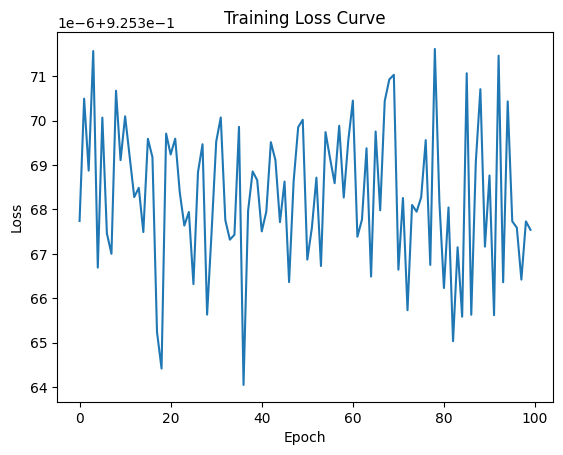

In [57]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [83]:
def test(test_loader, model, criter):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for _, data in enumerate(test_loader):
            img, _ = data
            output = model(img)
            loss = criter(output, img)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Average Loss: {avg_loss:.4f}')


#model=torch.jit.load('cnn_deffusion.pt')
#print(model)
model=torch.load('cnn_deffusion.pth')
model.load_state_dict(torch.load('cnn_deffusion.pth'))
test(test_loader, model, criter)


AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'